In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style('whitegrid')

## refer
https://www.zhihu.com/tardis/zm/art/29994599?source_id=1005


https://www.kaggle.com/code/faressayah/lending-club-loan-defaulters-prediction/notebook 

## Step0. 

In [2]:
data = pd.read_csv('./dataset//LoanStats_2017Q2.csv' , encoding='latin-1')
data.head()

C:\Users\haiwu\AppData\Local\Temp\ipykernel_36820\3546809514.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./dataset//LoanStats_2017Q2.csv' , encoding='latin-1')


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,7500.0,7500.0,7500.0,36 months,7.35%,232.79,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,20000.0,20000.0,20000.0,36 months,9.44%,640.10,B,B1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,12000.0,12000.0,12000.0,36 months,9.44%,384.06,B,B1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,6025.0,6025.0,6025.0,36 months,15.05%,209.01,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,4000.0,4000.0,4000.0,36 months,7.97%,125.30,A,A5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
check_null = data.isnull().sum(axis=0).sort_values(ascending=False)/float(len(data))
print(check_null[check_null > 0.2])

url                                           1.000000
member_id                                     1.000000
desc                                          1.000000
id                                            0.999981
settlement_percentage                         0.997174
settlement_amount                             0.997174
settlement_date                               0.997174
settlement_status                             0.997174
debt_settlement_flag_date                     0.997174
settlement_term                               0.997174
orig_projected_additional_accrued_interest    0.996548
hardship_type                                 0.995941
payment_plan_start_date                       0.995941
hardship_reason                               0.995941
hardship_status                               0.995941
deferral_term                                 0.995941
hardship_start_date                           0.995941
hardship_end_date                             0.995941
hardship_a

In [4]:
thresh_count = len(data)*0.4
data = data.dropna(thresh=thresh_count, axis=1)
data.isnull().sum(axis=0).sort_values(ascending=False)/float(len(data)) 

mths_since_last_delinq    0.484775
next_pymnt_d              0.229230
il_util                   0.126900
mths_since_recent_inq     0.113330
emp_title                 0.064332
                            ...   
total_pymnt_inv           0.000019
total_pymnt               0.000019
out_prncp_inv             0.000019
out_prncp                 0.000019
debt_settlement_flag      0.000019
Length: 103, dtype: float64

In [5]:
data.to_csv('./dataset/loans_2017q2_s1.csv', index = False)

## Step1. Object filter

In [57]:
loans = pd.read_csv('./dataset/loans_2017q2_s1.csv',encoding='latin-1') 
loans.dtypes.value_counts()

float64    78
object     25
Name: count, dtype: int64

In [58]:
loans = loans.loc[:,loans.apply(pd.Series.nunique) != 1]
loans.dtypes.value_counts()

float64    77
object     25
Name: count, dtype: int64

In [59]:
objectColumns = loans.select_dtypes(include=["object"]).columns
loans[objectColumns].isnull().sum().sort_values(ascending=False)

next_pymnt_d            24173
emp_title                6784
emp_length               6699
last_pymnt_d              124
revol_util                 77
term                        2
addr_state                  2
disbursement_method         2
hardship_flag               2
application_type            2
last_credit_pull_d          2
initial_list_status         2
earliest_cr_line            2
title                       2
zip_code                    2
int_rate                    2
purpose                     2
pymnt_plan                  2
loan_status                 2
issue_d                     2
verification_status         2
home_ownership              2
sub_grade                   2
grade                       2
debt_settlement_flag        2
dtype: int64

In [60]:
loans['int_rate'] = loans['int_rate'].str.rstrip('%').astype('float')
loans['revol_util'] = loans['revol_util'].str.rstrip('%').astype('float')

In [61]:
#删除对模型没有意义的列
# sub_grade：与Grade的信息重复
# emp_title ：缺失值较多，同时不能反映借款人收入或资产的真实情况
# zip_code：地址邮编，邮编显示不全，没有意义
# addr_state：申请地址所属州，不能反映借款人的偿债能力
# last_credit_pull_d ：LendingClub平台最近一个提供贷款的时间，没有意义
# policy_code ： 变量信息全为1
# pymnt_plan 基本是n
# title： title与purpose的信息重复，同时title的分类信息更加离散
# next_pymnt_d : 下一个付款时间，没有意义
# policy_code : 没有意义
# collection_recovery_fee: 全为0，没有意义
# earliest_cr_line : 记录的是借款人发生第一笔借款的时间
# issue_d ： 贷款发行时间，这里提前向模型泄露了信息
# last_pymnt_d、collection_recovery_fee、last_pymnt_amnt： 预测贷款违约模型是贷款前的风险控制手段，这些贷后信息都会影响我们训练模型的效果，在此将这些信息删除
columns_to_drop = ['sub_grade', 'emp_title',  'title', 'zip_code', 'addr_state', 
             'mths_since_last_delinq' ,'initial_list_status','title','issue_d','last_pymnt_d','last_pymnt_amnt',
             'next_pymnt_d','last_credit_pull_d','policy_code','collection_recovery_fee', 'earliest_cr_line']
existing_columns = loans.columns
columns_to_drop_existing = [column for column in columns_to_drop if column in existing_columns]
print(columns_to_drop_existing)
loans = loans.drop(columns_to_drop_existing, axis=1)

['sub_grade', 'emp_title', 'title', 'zip_code', 'addr_state', 'mths_since_last_delinq', 'initial_list_status', 'title', 'issue_d', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collection_recovery_fee', 'earliest_cr_line']


In [68]:
objectColumns = loans.select_dtypes(include=["object"]).columns
for col in objectColumns:
    print("col=",col,", types=", loans[col].nunique(),", sample=", loans[col].sample(3).values)
loans[objectColumns].isnull().sum().sort_values(ascending=False)

col= term , types= 2 , sample= [' 36 months' ' 36 months' ' 60 months']
col= grade , types= 7 , sample= ['A' 'B' 'A']
col= emp_length , types= 12 , sample= ['5 years' '1 year' '3 years']
col= home_ownership , types= 5 , sample= ['MORTGAGE' 'MORTGAGE' 'MORTGAGE']
col= verification_status , types= 3 , sample= ['Not Verified' 'Source Verified' 'Not Verified']
col= loan_status , types= 7 , sample= ['Current' 'Current' 'Fully Paid']
col= pymnt_plan , types= 2 , sample= ['n' 'n' 'n']
col= purpose , types= 13 , sample= ['credit_card' 'debt_consolidation' 'car']
col= application_type , types= 2 , sample= ['Individual' 'Individual' 'Individual']
col= hardship_flag , types= 2 , sample= ['N' 'N' 'N']
col= disbursement_method , types= 2 , sample= ['Cash' 'Cash' 'Cash']
col= debt_settlement_flag , types= 2 , sample= ['N' 'N' 'N']


term                    0
grade                   0
emp_length              0
home_ownership          0
verification_status     0
loan_status             0
pymnt_plan              0
purpose                 0
application_type        0
hardship_flag           0
disbursement_method     0
debt_settlement_flag    0
dtype: int64

In [66]:
loans["emp_length"] = loans["emp_length"].fillna("Unknown")
loans = loans.dropna(subset = objectColumns)
loans[objectColumns].isnull().sum().sort_values(ascending=False)

term                    0
grade                   0
emp_length              0
home_ownership          0
verification_status     0
loan_status             0
pymnt_plan              0
purpose                 0
application_type        0
hardship_flag           0
disbursement_method     0
debt_settlement_flag    0
dtype: int64

In [67]:
loans.select_dtypes(include = ['object']).head()
# term：贷款期限，表示贷款的还款周期长度，可能的取值为 "36 months"（36个月）或 "60 months"（60个月）。
# grade：贷款评级，表示贷款的信用评级，可能的取值为 "A"、"B"、"C"、"D"、"E" 或 "F"，其中 "A" 表示最高评级，"F" 表示最低评级。
# emp_length：就业年限，表示借款人的工作经验年限，可能的取值为 "10+ years"（10年以上）、"2 years"（2年）、"3 years"（3年）等。
# home_ownership：住所所有权，表示借款人的住房所有情况，可能的取值为 "RENT"（租赁）、"OWN"（自有）、"MORTGAGE"（按揭）或 "OTHER"（其他）。
# verification_status：收入验证状态，表示借款人的收入是否经过验证，可能的取值为 "Verified"（已验证）、"Source Verified"（来源已验证）或 "Not Verified"（未验证）。
# *loan_status：贷款状态，表示贷款的当前状态，可能的取值包括 "Fully Paid"（已全额还清）、"Charged Off"（已冲销）等。
# pymnt_plan：还款计划，表示借款人是否有特定的还款计划，可能的取值为 "y"（是）或 "n"（否）。
# purpose：贷款目的，表示借款人借款的目的，可能的取值包括 "debt_consolidation"（债务合并）、"credit_card"（信用卡）、"home_improvement"（家庭装修）等。
# application_type：申请类型，表示借款人的贷款申请类型，可能的取值为 "Individual"（个人）或 "Joint App"（联合申请）。
# hardship_flag：困难标志，表示借款人是否遇到困难情况，可能的取值为 "Y"（是）或 "N"（否）。
# disbursement_method：放款方式，表示贷款的放款方式，可能的取值为 "Cash"（现金）或 "DirectPay"（直接支付）。
# debt_settlement_flag：债务结算标志，表示贷款是否进行债务结算，可能的取值为 "Y"（是）或 "N"（否）。

,term,grade,emp_length,home_ownership,verification_status,loan_status,pymnt_plan,purpose,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,36 months,A,10+ years,MORTGAGE,Source Verified,Current,n,debt_consolidation,Individual,N,Cash,N
1,36 months,B,< 1 year,RENT,Not Verified,Current,n,credit_card,Individual,N,Cash,N
2,36 months,B,10+ years,MORTGAGE,Not Verified,Current,n,debt_consolidation,Individual,N,Cash,N
3,36 months,C,7 years,MORTGAGE,Not Verified,Fully Paid,n,home_improvement,Individual,N,Cash,N
4,36 months,A,7 years,MORTGAGE,Not Verified,Current,n,debt_consolidation,Individual,N,Cash,N


In [70]:
objectColumns = loans.select_dtypes(include=["object"]).columns
for col in objectColumns:
    print("col=",col,", n_unique=", loans[col].nunique(),", unique=", loans[col].unique())

col= term , n_unique= 2 , unique= [' 36 months' ' 60 months']
col= grade , n_unique= 7 , unique= ['A' 'B' 'C' 'D' 'F' 'E' 'G']
col= emp_length , n_unique= 12 , unique= ['10+ years' '< 1 year' '7 years' 'Unknown' '2 years' '1 year' '3 years'
 '9 years' '8 years' '5 years' '6 years' '4 years']
col= home_ownership , n_unique= 5 , unique= ['MORTGAGE' 'RENT' 'OWN' 'ANY' 'NONE']
col= verification_status , n_unique= 3 , unique= ['Source Verified' 'Not Verified' 'Verified']
col= loan_status , n_unique= 7 , unique= ['Current' 'Fully Paid' 'Charged Off' 'In Grace Period'
 'Late (31-120 days)' 'Late (16-30 days)' 'Default']
col= pymnt_plan , n_unique= 2 , unique= ['n' 'y']
col= purpose , n_unique= 13 , unique= ['debt_consolidation' 'credit_card' 'home_improvement' 'vacation' 'house'
 'other' 'major_purchase' 'car' 'medical' 'small_business' 'moving'
 'renewable_energy' 'wedding']
col= application_type , n_unique= 2 , unique= ['Individual' 'Joint App']
col= hardship_flag , n_unique= 2 , unique= ['

In [71]:
loans.to_csv('./dataset/loans_2017q2_s2.csv', index = False)

## Step2 Float filter

In [72]:
loans = pd.read_csv('./dataset/loans_2017q2_s2.csv',encoding='latin-1') 

In [73]:
loans.select_dtypes(include=[np.number]).isnull().sum().sort_values(ascending=False)

il_util                       13380
mths_since_recent_inq         11949
num_tl_120dpd_2m               5278
mo_sin_old_il_acct             2652
mths_since_rcnt_il             2652
                              ...  
tot_cur_bal                       0
tot_coll_amt                      0
acc_now_delinq                    0
collections_12_mths_ex_med        0
total_il_high_credit_limit        0
Length: 76, dtype: int64

In [74]:
numColumns = loans.select_dtypes(include=[np.number]).columns
print(numColumns)
for column in numColumns:
    mean_value = loans[column].mean()
    loans[column].fillna(mean_value, inplace=True)
loans.select_dtypes(include=[np.number]).isnull().sum().sort_values(ascending=False)

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'n

loan_amnt                     0
mo_sin_old_rev_tl_op          0
num_actv_bc_tl                0
num_accts_ever_120_pd         0
mths_since_recent_inq         0
                             ..
tot_coll_amt                  0
acc_now_delinq                0
collections_12_mths_ex_med    0
recoveries                    0
total_il_high_credit_limit    0
Length: 76, dtype: int64

In [75]:
loans.isnull().sum().sort_values(ascending=False)

loan_amnt                0
funded_amnt              0
num_actv_bc_tl           0
num_accts_ever_120_pd    0
mths_since_recent_inq    0
                        ..
total_rec_int            0
total_rec_prncp          0
total_pymnt_inv          0
total_pymnt              0
debt_settlement_flag     0
Length: 88, dtype: int64

In [76]:
loans.to_csv('./dataset/loans_2017q2_s3.csv', index = False)

## Step3. Feature Abstraction

In [76]:
loans =  pd.read_csv('./dataset/loans_2017q2_s3.csv' , encoding='latin-1')
loans.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,7500.0,7500.0,7500.0,36 months,7.35,232.79,A,10+ years,MORTGAGE,113000.0,Source Verified,Current,n,debt_consolidation,21.43,0.0,0.0,7.0,0.0,30569.0,62.9,16.0,5180.67,5180.67,2785.820000,2785.82,2319.33,466.49,0.0,0.0,0.0,Individual,0.0,0.0,356811.0,0.0,3.0,1.0,4.0,12.0,60352.0,78.000000,0.0,1.0,25792.0,75.0,42600.0,1.0,4.0,0.0,5.0,50973.0,9208.0,56.511686,0.0,0.0,114.0,218.0,14.0,12.0,4.0,218.0,14.000000,0.0,1.0,3.0,1.0,1.0,9.0,3.0,3.0,3.0,7.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,417686.0,90921.0,35000.0,92511.0,N,Cash,N
1,20000.0,20000.0,20000.0,36 months,9.44,640.10,B,< 1 year,RENT,70000.0,Not Verified,Current,n,credit_card,25.61,2.0,0.0,8.0,0.0,20589.0,81.7,14.0,10891.95,10891.95,10654.980000,10654.98,9108.05,1546.93,0.0,0.0,0.0,Individual,0.0,0.0,37895.0,1.0,2.0,0.0,0.0,27.0,17306.0,41.000000,1.0,3.0,19372.0,56.0,25200.0,0.0,0.0,0.0,3.0,5414.0,2403.0,89.500000,0.0,0.0,160.0,298.0,6.0,6.0,0.0,6.0,7.104928,0.0,2.0,3.0,3.0,5.0,3.0,6.0,11.0,3.0,8.0,0.0,0.0,0.0,1.0,84.6,33.3,0.0,0.0,67717.0,37895.0,22900.0,42517.0,N,Cash,N
2,12000.0,12000.0,12000.0,36 months,9.44,384.06,B,10+ years,MORTGAGE,70000.0,Not Verified,Current,n,debt_consolidation,18.34,0.0,0.0,14.0,1.0,15025.0,58.2,30.0,8369.67,8369.67,4592.990000,4592.99,3630.33,962.66,0.0,0.0,0.0,Individual,0.0,0.0,211227.0,0.0,1.0,0.0,0.0,41.0,12438.0,40.000000,2.0,3.0,5227.0,49.0,25800.0,0.0,0.0,2.0,4.0,15088.0,0.0,102.300000,0.0,0.0,160.0,238.0,10.0,10.0,6.0,29.0,11.000000,0.0,2.0,8.0,2.0,6.0,7.0,11.0,17.0,8.0,14.0,0.0,0.0,0.0,2.0,96.7,100.0,1.0,0.0,267482.0,27463.0,9200.0,30780.0,N,Cash,N
3,6025.0,6025.0,6025.0,36 months,15.05,209.01,C,7 years,MORTGAGE,46350.0,Not Verified,Fully Paid,n,home_improvement,8.88,0.0,0.0,11.0,0.0,12425.0,44.9,27.0,0.00,0.00,6578.749167,6578.75,6025.00,553.75,0.0,0.0,0.0,Individual,0.0,0.0,121311.0,1.0,0.0,1.0,2.0,10.0,0.0,68.733097,1.0,2.0,1950.0,45.0,27700.0,1.0,5.0,3.0,6.0,11028.0,11017.0,37.400000,0.0,0.0,86.0,180.0,8.0,2.0,2.0,8.0,8.000000,0.0,6.0,9.0,6.0,16.0,4.0,9.0,21.0,9.0,11.0,0.0,0.0,0.0,4.0,100.0,0.0,0.0,0.0,137700.0,12425.0,17600.0,0.0,N,Cash,N
4,4000.0,4000.0,4000.0,36 months,7.97,125.30,A,7 years,MORTGAGE,50000.0,Not Verified,Current,n,debt_consolidation,13.03,0.0,0.0,11.0,0.0,3870.0,34.6,11.0,2667.63,2667.63,1599.170000,1599.17,1332.37,266.80,0.0,0.0,0.0,Individual,0.0,133.0,162678.0,0.0,1.0,0.0,0.0,36.0,6717.0,43.000000,1.0,1.0,1913.0,40.0,11200.0,0.0,0.0,1.0,2.0,14789.0,1657.0,66.900000,0.0,0.0,36.0,50.0,8.0,8.0,2.0,8.0,9.000000,0.0,2.0,5.0,2.0,2.0,1.0,8.0,8.0,5.0,11.0,0.0,0.0,0.0,2.0,90.9,50.0,0.0,0.0,191473.0,10587.0,5000.0,15523.0,N,Cash,N


In [77]:
objectColumns = loans.select_dtypes(include=["object"]).columns
for col in objectColumns:
    print("col=",col,", n_unique=", loans[col].nunique(),", unique=", loans[col].unique())

col= term , n_unique= 2 , unique= [' 36 months' ' 60 months']
col= grade , n_unique= 7 , unique= ['A' 'B' 'C' 'D' 'F' 'E' 'G']
col= emp_length , n_unique= 12 , unique= ['10+ years' '< 1 year' '7 years' 'Unknown' '2 years' '1 year' '3 years'
 '9 years' '8 years' '5 years' '6 years' '4 years']
col= home_ownership , n_unique= 5 , unique= ['MORTGAGE' 'RENT' 'OWN' 'ANY' 'NONE']
col= verification_status , n_unique= 3 , unique= ['Source Verified' 'Not Verified' 'Verified']
col= loan_status , n_unique= 7 , unique= ['Current' 'Fully Paid' 'Charged Off' 'In Grace Period'
 'Late (31-120 days)' 'Late (16-30 days)' 'Default']
col= pymnt_plan , n_unique= 2 , unique= ['n' 'y']
col= purpose , n_unique= 13 , unique= ['debt_consolidation' 'credit_card' 'home_improvement' 'vacation' 'house'
 'other' 'major_purchase' 'car' 'medical' 'small_business' 'moving'
 'renewable_energy' 'wedding']
col= application_type , n_unique= 2 , unique= ['Individual' 'Joint App']
col= hardship_flag , n_unique= 2 , unique= ['

In [78]:
numColumns = loans.select_dtypes(include=np.number).columns
for i in range(len(numColumns)):
    print(f"i={i},col={numColumns[i]}")
numdf = loans[numColumns]

i=0,col=loan_amnt
i=1,col=funded_amnt
i=2,col=funded_amnt_inv
i=3,col=int_rate
i=4,col=installment
i=5,col=annual_inc
i=6,col=dti
i=7,col=delinq_2yrs
i=8,col=inq_last_6mths
i=9,col=open_acc
i=10,col=pub_rec
i=11,col=revol_bal
i=12,col=revol_util
i=13,col=total_acc
i=14,col=out_prncp
i=15,col=out_prncp_inv
i=16,col=total_pymnt
i=17,col=total_pymnt_inv
i=18,col=total_rec_prncp
i=19,col=total_rec_int
i=20,col=total_rec_late_fee
i=21,col=recoveries
i=22,col=collections_12_mths_ex_med
i=23,col=acc_now_delinq
i=24,col=tot_coll_amt
i=25,col=tot_cur_bal
i=26,col=open_acc_6m
i=27,col=open_act_il
i=28,col=open_il_12m
i=29,col=open_il_24m
i=30,col=mths_since_rcnt_il
i=31,col=total_bal_il
i=32,col=il_util
i=33,col=open_rv_12m
i=34,col=open_rv_24m
i=35,col=max_bal_bc
i=36,col=all_util
i=37,col=total_rev_hi_lim
i=38,col=inq_fi
i=39,col=total_cu_tl
i=40,col=inq_last_12m
i=41,col=acc_open_past_24mths
i=42,col=avg_cur_bal
i=43,col=bc_open_to_buy
i=44,col=bc_util
i=45,col=chargeoff_within_12_mths
i=46,c

In [79]:
# 多值有序排列
print(pd.value_counts(loans["loan_status"]),"----")
print(pd.value_counts(loans["emp_length"]),"----")
print(pd.value_counts(loans["grade"]),"----")
mapping_dict = {
    "loan_status": {
        'Current':0,
        'Fully Paid':0,
        'In Grace Period':1,
        'Late (31-120 days)':1,
        'Late (16-30 days)':1,
        'Charged Off':1,
        'Default':1
    },
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "Unknown": 0
    },
    "grade":{
        "A": 1,
        "B": 2,
        "C": 3,
        "D": 4,
        "E": 5,
        "F": 6,
        "G": 7
    },
}
loans = loans.replace(mapping_dict)


loan_status
Current               77347
Fully Paid            19652
Charged Off            4519
Late (31-120 days)     2089
In Grace Period        1083
Late (16-30 days)       598
Default                 163
Name: count, dtype: int64 ----
emp_length
10+ years    35438
2 years       9914
< 1 year      9542
3 years       8495
1 year        7034
Unknown       6697
4 years       6453
5 years       6382
6 years       4526
7 years       3847
9 years       3828
8 years       3295
Name: count, dtype: int64 ----
grade
C    36880
B    31301
A    17898
D    12015
E     4847
F     1725
G      785
Name: count, dtype: int64 ----


In [80]:
print(pd.value_counts(loans["loan_status"]),"----")
print(pd.value_counts(loans["emp_length"]),"----")
print(pd.value_counts(loans["grade"]),"----")

loan_status
0    96999
1     8452
Name: count, dtype: int64 ----
emp_length
10    35438
0     16239
2      9914
3      8495
1      7034
4      6453
5      6382
6      4526
7      3847
9      3828
8      3295
Name: count, dtype: int64 ----
grade
3    36880
2    31301
1    17898
4    12015
5     4847
6     1725
7      785
Name: count, dtype: int64 ----


In [81]:
# 多值无序排列
onehot_cols = ["term","home_ownership", "verification_status","pymnt_plan","purpose","application_type","hardship_flag","disbursement_method","debt_settlement_flag"]
dummy_df = pd.get_dummies(loans[onehot_cols])
print(dummy_df)
loans = pd.concat([loans, dummy_df], axis=1)
loans = loans.drop(onehot_cols, axis=1)

        term_ 36 months  term_ 60 months  home_ownership_ANY  \
0                  True            False               False   
1                  True            False               False   
2                  True            False               False   
3                  True            False               False   
4                  True            False               False   
...                 ...              ...                 ...   
105446            False             True               False   
105447             True            False               False   
105448             True            False               False   
105449             True            False               False   
105450            False             True               False   

        home_ownership_MORTGAGE  home_ownership_NONE  home_ownership_OWN  \
0                          True                False               False   
1                         False                False               False   
2  

In [82]:
loans.info() # 所有变量转为np.number

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105451 entries, 0 to 105450
Columns: 112 entries, loan_amnt to debt_settlement_flag_Y
dtypes: bool(33), float64(76), int64(3)
memory usage: 66.9 MB


In [88]:
ylabel = "loan_status"
xlabel = list(loans.columns)
xlabel.remove(ylabel)
cols = loans.select_dtypes(include=['int64','float64']).columns
cols = cols.drop(ylabel)
loans_cp  = loans.copy(deep=True)
# 标准化数据
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
loans_cp[cols] = ss.fit_transform(loans_cp[cols])
print(loans_cp.describe())


          loan_amnt   funded_amnt  funded_amnt_inv      int_rate  \
count  1.054510e+05  1.054510e+05     1.054510e+05  1.054510e+05   
mean   2.317917e-17  2.317917e-17    -2.264012e-17 -2.264012e-17   
std    1.000005e+00  1.000005e+00     1.000005e+00  1.000005e+00   
min   -1.433629e+00 -1.433629e+00    -1.433631e+00 -1.544435e+00   
25%   -8.006371e-01 -8.006371e-01    -8.004576e-01 -6.505594e-01   
50%   -2.731436e-01 -2.731436e-01    -2.728129e-01 -1.289702e-01   
75%    5.708461e-01  5.708461e-01     5.714185e-01  5.244706e-01   
max    2.680820e+00  2.680820e+00     2.681997e+00  3.432961e+00   

        installment         grade    emp_length    annual_inc    loan_status  \
count  1.054510e+05  1.054510e+05  1.054510e+05  1.054510e+05  105451.000000   
mean   5.390505e-17 -1.552466e-16  6.940276e-17 -1.920368e-16       0.080151   
std    1.000005e+00  1.000005e+00  1.000005e+00  1.000005e+00       0.271528   
min   -1.451497e+00 -1.385154e+00 -1.402041e+00 -1.179296e+00      

In [93]:

x = loans_cp[xlabel]
y = loans_cp[ylabel]
print(x.shape,y.shape)
# 采用的是Wrapper方法，通过暴力的递归特征消除 (Recursive Feature Elimination)方法筛选30个与目标变量相关性最强的特征
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
rfe = RFE(estimator=model,n_features_to_select=30) #通过递归选择特征，选择30个特征
rfe = rfe.fit(x, y)
print(rfe.support_)
print(rfe.ranking_) #ranking 为 1代表被选中，其他则代表未被选中

(105451, 111) (105451,)
[ True  True  True  True  True  True False False False False False False
 False False False  True  True  True  True  True  True  True  True  True
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False  True False False False False False False False False
 False False  True False False False  True False  True False False False
 False False False False  True  True False False False False  True  True
  True False False False False False False False False  True  True False
 False  True  True]
[ 1  1  1  1  1  1 28  6 61 37 48 80 68 78 39  1  1  1  1  1  1  1  1  1
 77 55 43  1 64 59 10 19 65 47 26  8 25 17 60 52 30 70 62  5 34 16 40 79
 71 51 82 29 72 76 35 63 58 23 11 24  4  1 66  1 12 22 56 36 42  9 69 41
 54 67  1 53  3 46  1 15  1 33 75 31 32  2 45 44  1  1 18 74 81 38  1  1
  1 50 

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'grade', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'tot_cur_bal', 'num_il_tl',
       'num_rev_accts', 'tot_hi_cred_lim', 'term_ 36 months',
       'home_ownership_ANY', 'pymnt_plan_n', 'pymnt_plan_y', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'hardship_flag_N',
       'hardship_flag_Y', 'debt_settlement_flag_N', 'debt_settlement_flag_Y'],
      dtype='object')


<Axes: title={'center': 'Pearson Correlation of Features'}>

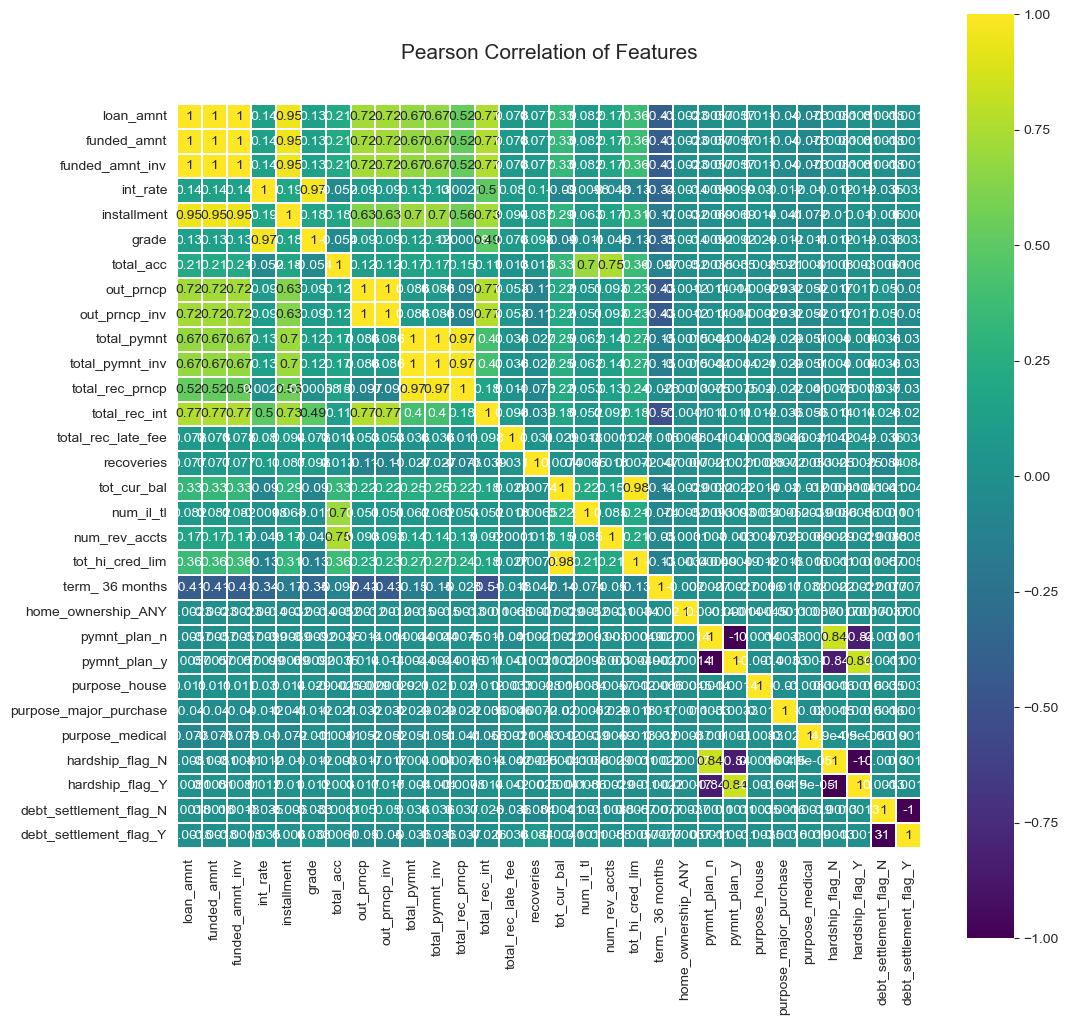

In [94]:
col_filter = x.columns[rfe.support_]
print(col_filter) # 查看通过递归特征消除法筛选的变量
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(x[col_filter].corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [98]:
drop_col = ['funded_amnt', 'funded_amnt_inv','installment', 
            'int_rate',
            'out_prncp_inv',
            'total_pymnt_inv', 'total_rec_prncp',
            'tot_hi_cred_lim',
            'pymnt_plan_n',
            'hardship_flag_N',
            'debt_settlement_flag_N'
            ]
col_new = col_filter.drop(drop_col)
print(f"col_new = {col_new},len = {len(col_new)}")
col_new = col_new.append(pd.Index([ylabel]))
loans_simple = loans_cp[col_new]
print(f"loans_simple = {loans_simple.describe()}")

col_new = Index(['loan_amnt', 'grade', 'total_acc', 'out_prncp', 'total_pymnt',
       'total_rec_int', 'total_rec_late_fee', 'recoveries', 'tot_cur_bal',
       'num_il_tl', 'num_rev_accts', 'term_ 36 months', 'home_ownership_ANY',
       'pymnt_plan_y', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'hardship_flag_Y', 'debt_settlement_flag_Y'],
      dtype='object'),len = 19
loans_simple =           loan_amnt         grade     total_acc     out_prncp   total_pymnt  \
count  1.054510e+05  1.054510e+05  1.054510e+05  1.054510e+05  1.054510e+05   
mean   2.317917e-17 -1.552466e-16  1.495865e-16  1.892067e-16  2.803063e-17   
std    1.000005e+00  1.000005e+00  1.000005e+00  1.000005e+00  1.000005e+00   
min   -1.433629e+00 -1.385154e+00 -1.839720e+00 -1.040066e+00 -1.114739e+00   
25%   -8.006371e-01 -5.448692e-01 -7.405329e-01 -8.660096e-01 -6.244846e-01   
50%   -2.731436e-01  2.954157e-01 -1.486632e-01 -2.422139e-01 -3.066141e-01   
75%    5.708461e-01  2.954157e

In [99]:
loans_simple.to_csv('./dataset/loans_2017q2_s4_simple.csv', index = False)

In [62]:
loans_cp.to_csv('./dataset/loans_2017q2_s4.csv', index = False)

## Step4. Model

### Forest & LR

In [63]:
loans = pd.read_csv('./dataset/loans_2017q2_s4.csv',encoding='latin-1') 

In [100]:
loans = pd.read_csv('./dataset/loans_2017q2_s4_simple.csv',encoding='latin-1') 

In [101]:
print(loans.shape)
loans.head()

(105451, 20)


,loan_amnt,grade,total_acc,out_prncp,total_pymnt,total_rec_int,total_rec_late_fee,recoveries,tot_cur_bal,num_il_tl,num_rev_accts,term_ 36 months,home_ownership_ANY,pymnt_plan_y,purpose_house,purpose_major_purchase,purpose_medical,hardship_flag_Y,debt_settlement_flag_Y,loan_status
0,-0.747888,-1.385154,-0.655980,-0.397895,-0.691128,-0.791511,-0.118811,-0.101088,1.269507,0.051829,-1.335560,True,False,False,False,False,False,False,False,0
1,0.570846,-0.544869,-0.825086,0.310047,0.505455,-0.096478,-0.118811,-0.101088,-0.666081,-0.753738,-0.317698,True,False,False,False,False,False,False,False,0
2,-0.273144,-0.544869,0.527759,-0.002602,-0.416330,-0.472331,-0.118811,-0.101088,0.385918,-0.216694,0.445699,True,False,False,False,False,False,False,False,0
3,-0.903498,0.295416,0.274101,-1.040066,-0.114376,-0.735377,-0.118811,-0.101088,-0.159806,-0.619477,0.954630,True,False,False,False,False,False,False,False,0
4,-1.117133,-1.385154,-1.078744,-0.709400,-0.871570,-0.919969,-0.118811,-0.101088,0.091261,-1.022260,-0.699396,True,False,False,False,False,False,False,False,0


In [102]:
seed = 24
from sklearn.model_selection import train_test_split
train_ds, test_ds = train_test_split(loans, test_size=0.25, random_state=24)
ylabel = "loan_status"
print("shape of train_dataset:",train_ds.shape,",test_dataset:",test_ds.shape)
xlabel = loans.columns.drop(ylabel)
train_x, train_y = train_ds[xlabel], train_ds[ylabel]
test_x, test_y = test_ds[xlabel], test_ds[ylabel]
print("shape of train:",train_x.shape,train_y.shape,", test:",test_x.shape,test_y.shape,"\n----")
print(type(train_x), train_x.info(), type(train_y), train_y.info())

shape of train_dataset: (79088, 20) ,test_dataset: (26363, 20)
shape of train: (79088, 19) (79088,) , test: (26363, 19) (26363,) 
----
<class 'pandas.core.frame.DataFrame'>
Index: 79088 entries, 57802 to 899
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   loan_amnt               79088 non-null  float64
 1   grade                   79088 non-null  float64
 2   total_acc               79088 non-null  float64
 3   out_prncp               79088 non-null  float64
 4   total_pymnt             79088 non-null  float64
 5   total_rec_int           79088 non-null  float64
 6   total_rec_late_fee      79088 non-null  float64
 7   recoveries              79088 non-null  float64
 8   tot_cur_bal             79088 non-null  float64
 9   num_il_tl               79088 non-null  float64
 10  num_rev_accts           79088 non-null  float64
 11  term_ 36 months         79088 non-null  bool   
 12  home_ownersh

In [103]:
train_x.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,79088.0,-0.002625,0.999708,-1.433629,-0.800637,-0.273144,0.570846,2.680820
grade,79088.0,0.000496,1.000236,-1.385154,-0.544869,0.295416,0.295416,3.656555
total_acc,79088.0,0.000836,1.002318,-1.839720,-0.740533,-0.148663,0.527759,10.335886
out_prncp,79088.0,-0.002545,0.998991,-1.040066,-0.866771,-0.246665,0.574063,3.469464
total_pymnt,79088.0,-0.000230,1.004229,-1.114739,-0.625555,-0.308345,0.280458,6.381197
total_rec_int,79088.0,-0.000850,1.000287,-1.091598,-0.717192,-0.319991,0.408105,7.029770
total_rec_late_fee,79088.0,-0.003292,0.964210,-0.118811,-0.118811,-0.118811,-0.118811,61.026677
recoveries,79088.0,-0.000115,1.008397,-0.101088,-0.101088,-0.101088,-0.101088,62.090862
tot_cur_bal,79088.0,-0.001205,0.996585,-0.896076,-0.714377,-0.388415,0.445087,20.752100
num_il_tl,79088.0,0.000552,0.998860,-1.156522,-0.619477,-0.216694,0.320351,12.806635


In [105]:
seed = 24
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=500)
lr.fit(train_x, train_y)

from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10,random_state=seed)
forest.fit(train_x, train_y)


RandomForestClassifier(n_estimators=10, random_state=24)

In [106]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

predict_y = lr.predict(test_x)
print("-"*20 + "lr" + "-"*20)
print(classification_report(test_y, predict_y))
print("Test set accuracy score : {:.5f}".format(accuracy_score(predict_y, test_y,)))
print("Area under the ROC curve : %f" % roc_auc_score(test_y, predict_y))

predict_y = forest.predict(test_x)
print("-"*20 + "forest" + "-"*20)
print(classification_report(test_y, predict_y))
print("Test set accuracy score : {:.5f}".format(accuracy_score(predict_y, test_y,)))
print("Area under the ROC curve : %f" % roc_auc_score(test_y, predict_y))



--------------------lr--------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     24269
           1       0.97      0.60      0.74      2094

    accuracy                           0.97     26363
   macro avg       0.97      0.80      0.86     26363
weighted avg       0.97      0.97      0.96     26363

Test set accuracy score : 0.96685
Area under the ROC curve : 0.800472
--------------------forest--------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     24269
           1       0.96      0.66      0.78      2094

    accuracy                           0.97     26363
   macro avg       0.96      0.83      0.88     26363
weighted avg       0.97      0.97      0.97     26363

Test set accuracy score : 0.97064
Area under the ROC curve : 0.829149


### NNModel

In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
    
class NNModel(nn.Module):
    def __init__(self, num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
        super(NNModel, self).__init__()

        self.num_columns = num_columns
        self.num_labels = num_labels

        layers = []
        layers.append(nn.BatchNorm1d(num_columns))
        layers.append(nn.Dropout(dropout_rates[0]))

        for i in range(len(hidden_units)):
            layers.append(nn.Linear(hidden_units[i-1] if i > 0 else num_columns, hidden_units[i]))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_units[i]))
            layers.append(nn.Dropout(dropout_rates[i+1]))

        layers.append(nn.Linear(hidden_units[-1] if hidden_units else num_columns, num_labels))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

        self.criterion = nn.BCELoss()
        # self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.metric = roc_auc_score

    def forward(self, x):
        return self.model(x)

    def compute_loss(self, outputs, targets):
        return self.criterion(outputs, targets)

    def compute_metric(self, outputs, targets):
        return self.metric(outputs, targets)

In [108]:

from torch.utils.data import DataLoader, TensorDataset

num_columns = train_x.shape[1]  # 输入特征的数量
num_labels = 1  # 输出标签的数量为1，因为是二分类问题
hidden_units = [150,150,150]  # 隐藏层的单元数量
dropout_rates = [0.1, 0, 0.1, 0]  # 随机失活的失活率
learning_rate = 1e-3  # 学习率
num_epochs = 20  # 迭代次数
batch_size = 32

def df_to_tensor(df):
    return torch.from_numpy(df.astype(np.double).values)
def eval(model):
    with torch.no_grad():
        model.eval() # 设置模型为评估模式
        train_outputs = model(train_x_tensor)
        train_auc = model.compute_metric(train_y, train_outputs.cpu().numpy())
        test_outputs = model(test_x_tensor)
        test_auc = model.compute_metric(test_y, test_outputs.cpu().numpy())
        return train_auc,test_auc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"available device is {device}")
gpu_count = torch.cuda.device_count()
for i in range(gpu_count):
    gpu_name = torch.cuda.get_device_name(i)
    print("GPU {}: {}".format(i, gpu_name))
train_x_tensor = df_to_tensor(train_x).float().to(device)
train_y_tensor = df_to_tensor(train_y).float().to(device)
test_x_tensor = df_to_tensor(test_x).float().to(device)
test_y_tensor = df_to_tensor(test_y).float().to(device)
train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

available device is cuda
GPU 0: NVIDIA GeForce RTX 3060 Laptop GPU


### Single

In [109]:
# single pointing training
from tqdm import tqdm
model = NNModel(num_columns, num_labels, hidden_units, dropout_rates, learning_rate).to(device)
# model = MLPModel(num_columns, num_labels, hidden_units, dropout_rates, learning_rate).to(device)
for epoch in range(num_epochs):
    tq = tqdm(train_loader)
    for batch_data, batch_labels in tq:
        # 将数据和标签转换为Tensor形式
        batch_labels = batch_labels.unsqueeze(1)  # 将标签的维度从(64,)变为(64, 1)
        # 前向传播
        outputs = model(batch_data)
        # 计算损失
        loss = model.compute_loss(outputs, batch_labels)
        # 反向传播和优化
        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()
        tq.set_description(f"training loss")
        tq.set_postfix({
            "loss": f"{loss.item():.4f}",
            "epoch": f"{epoch}"
        })
    # 打印每个epoch的损失
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    train_auc,test_auc = eval(model)
    print(f"Train AUC: {train_auc}, Test AUC: {test_auc}")

training loss: 100%|██████████| 2472/2472 [00:07<00:00, 330.98it/s, loss=0.0638, epoch=0]


Epoch 1/20, Loss: 0.06379693746566772
Train AUC: 0.9075807105330437, Test AUC: 0.9070023435590968


training loss: 100%|██████████| 2472/2472 [00:07<00:00, 352.29it/s, loss=0.0179, epoch=1]


Epoch 2/20, Loss: 0.01789719983935356
Train AUC: 0.9550878109371937, Test AUC: 0.9542533025749318


training loss: 100%|██████████| 2472/2472 [00:06<00:00, 374.03it/s, loss=0.1187, epoch=2]


Epoch 3/20, Loss: 0.1187400072813034
Train AUC: 0.9638494838882989, Test AUC: 0.9611734607999018


training loss: 100%|██████████| 2472/2472 [00:06<00:00, 383.60it/s, loss=0.0437, epoch=3]


Epoch 4/20, Loss: 0.0437234602868557
Train AUC: 0.961426868205245, Test AUC: 0.9575286831066457


training loss: 100%|██████████| 2472/2472 [00:06<00:00, 369.44it/s, loss=0.1994, epoch=4]


Epoch 5/20, Loss: 0.19941186904907227
Train AUC: 0.9660406073872577, Test AUC: 0.96304123595912


training loss: 100%|██████████| 2472/2472 [00:07<00:00, 338.44it/s, loss=0.4370, epoch=5]


Epoch 6/20, Loss: 0.4369768798351288
Train AUC: 0.9576910405219667, Test AUC: 0.9548791574915082


training loss: 100%|██████████| 2472/2472 [00:08<00:00, 300.30it/s, loss=0.0116, epoch=6]


Epoch 7/20, Loss: 0.011642741039395332
Train AUC: 0.9626131504930158, Test AUC: 0.959603623710888


training loss: 100%|██████████| 2472/2472 [00:15<00:00, 159.61it/s, loss=0.0222, epoch=7]


Epoch 8/20, Loss: 0.02223506197333336
Train AUC: 0.966972540432848, Test AUC: 0.9640462087562585


training loss: 100%|██████████| 2472/2472 [00:09<00:00, 265.93it/s, loss=0.0100, epoch=8]


Epoch 9/20, Loss: 0.009965416975319386
Train AUC: 0.9526555524496552, Test AUC: 0.9469070954676537


training loss: 100%|██████████| 2472/2472 [00:08<00:00, 305.86it/s, loss=0.0060, epoch=9]


Epoch 10/20, Loss: 0.006009811069816351
Train AUC: 0.9659074981920012, Test AUC: 0.9632538422519354


training loss: 100%|██████████| 2472/2472 [00:07<00:00, 321.64it/s, loss=0.0063, epoch=10]


Epoch 11/20, Loss: 0.00632565189152956
Train AUC: 0.966791032317257, Test AUC: 0.9640126191462036


training loss: 100%|██████████| 2472/2472 [00:07<00:00, 322.37it/s, loss=0.1429, epoch=11]


Epoch 12/20, Loss: 0.14291790127754211
Train AUC: 0.9673906205593414, Test AUC: 0.9645412668725807


training loss: 100%|██████████| 2472/2472 [00:07<00:00, 315.43it/s, loss=0.0280, epoch=12]


Epoch 13/20, Loss: 0.028013434261083603
Train AUC: 0.9688699433286823, Test AUC: 0.9637094566814655


training loss: 100%|██████████| 2472/2472 [00:07<00:00, 321.67it/s, loss=0.2151, epoch=13]


Epoch 14/20, Loss: 0.21506646275520325
Train AUC: 0.959885937668341, Test AUC: 0.9557768580219723


training loss: 100%|██████████| 2472/2472 [00:07<00:00, 318.72it/s, loss=0.0136, epoch=14]


Epoch 15/20, Loss: 0.013571731746196747
Train AUC: 0.9643575044136538, Test AUC: 0.9601502960903466


training loss: 100%|██████████| 2472/2472 [00:07<00:00, 316.51it/s, loss=0.2396, epoch=15]


Epoch 16/20, Loss: 0.2396070510149002
Train AUC: 0.9679441724655049, Test AUC: 0.9626095199369782


training loss: 100%|██████████| 2472/2472 [00:07<00:00, 320.06it/s, loss=0.3161, epoch=16]


Epoch 17/20, Loss: 0.3161364793777466
Train AUC: 0.9676222922349755, Test AUC: 0.9613222330593153


training loss: 100%|██████████| 2472/2472 [00:07<00:00, 325.36it/s, loss=0.3264, epoch=17]


Epoch 18/20, Loss: 0.3263852596282959
Train AUC: 0.9647690622933821, Test AUC: 0.9587786809913073


training loss: 100%|██████████| 2472/2472 [00:07<00:00, 316.85it/s, loss=0.0145, epoch=18]


Epoch 19/20, Loss: 0.014496998861432076
Train AUC: 0.9656037357941638, Test AUC: 0.9601361774346849


training loss: 100%|██████████| 2472/2472 [00:07<00:00, 318.60it/s, loss=0.0143, epoch=19]


Epoch 20/20, Loss: 0.014259178191423416
Train AUC: 0.9699438855385484, Test AUC: 0.964828756153717


### Federated Learning

In [110]:
from torch.utils.data import random_split, DataLoader
import copy
def split_dataset(dataset, num_client, batch_size):
    split_size = len(dataset) // num_client
    data_loaders = []
    for split in random_split(dataset,[split_size] * num_client):
        loader = DataLoader(split,batch_size=batch_size,shuffle=True)
        data_loaders.append(loader)
    return data_loaders

class Client:
    def __init__(
        self, 
        device,
        model,
        local_epoch = 1,
    ):
        self.device = device
        self.model = copy.deepcopy(model)
        self.model.to(device)
        self.local_epoch = local_epoch

    def train(self, dataloader: DataLoader):
        tq = tqdm(dataloader)
        for _ in range(self.local_epoch):
            loss_ema = None
            iter_loss_sum = 0
            n_iter = 0
            loss_ema_list = []
            avg_iter_loss_list = []
            for x, y in tq:
                x = x.to(self.device)
                y = y.unsqueeze(1)
                outputs = self.model(x)
                loss = self.model.compute_loss(outputs, y)
                self.model.optimizer.zero_grad()
                loss.backward()
                self.model.optimizer.step()
                if loss_ema is None:
                    loss_ema = loss.item()
                else:
                    loss_ema = 0.9 * loss_ema + 0.1 * loss.item()
                iter_loss_sum = iter_loss_sum + loss.item()
                n_iter = n_iter + 1
                tq.set_postfix({
                    "loss": f"{loss_ema:.4f}",
                    "iter_loss": f"{loss.item()}"
                })
            loss_ema_list.append(loss_ema)
            avg_iter_loss_list.append(iter_loss_sum / n_iter)
        return sum(loss_ema_list)/len(loss_ema_list),sum(avg_iter_loss_list)/len(avg_iter_loss_list)
    


In [112]:
# federated learning
from tqdm import tqdm
num_client = 4

dataloaders = split_dataset(train_dataset,num_client,batch_size)
# dataloaders = [train_loader]
glb_model = NNModel(num_columns, num_labels, hidden_units, dropout_rates, learning_rate).to(device)
clients = [Client(device,copy.deepcopy(glb_model)) for _ in range(num_client)]

# batch_data, batch_labels = next(iter(train_dataset))
# print(batch_data.shape,batch_labels.shape,len(train_dataset))
# print(batch_data[:5])
# for data_loaders in dataloaders:
#     batch_data, batch_labels = next(iter(data_loaders))
#     print(batch_data.shape,batch_labels.shape,len(data_loaders))
#     print(batch_data[:5])
print("--start--")
epochs = 20
for epoch in range(epochs):
      loss_ema_arr = []
      loss_iter_arr = []
      for cli,dataloader in zip(clients, dataloaders):
         # load global model
         cli.model.load_state_dict(copy.deepcopy(glb_model.state_dict()))
         loss_ema,loss_iter = cli.train(dataloader)
         loss_ema_arr.append(loss_ema)
         loss_iter_arr.append(loss_iter)
      # aggreaget the global model
      avg_loss_ema = sum(loss_ema_arr)/len(loss_ema_arr)
      avg_loss_iter = sum(loss_iter_arr)/len(loss_iter_arr)

      avg_params = clients[0].model.state_dict()
      for cli in clients[1:]:
        for k,v in cli.model.state_dict().items():
            avg_params[k] += v
        for k in avg_params.keys():
            avg_params[k] = avg_params[k] * (1/num_client) 
      glb_model.load_state_dict(avg_params)      
      
      train_auc, test_auc = eval(glb_model)
      print(f"epoch:{epoch}, loss_ema:{avg_loss_ema}, loss_iter:{avg_loss_iter}, train_auc:{train_auc}, test_auc:{test_auc}")

--start--


100%|██████████| 618/618 [00:01<00:00, 360.54it/s, loss=0.1925, iter_loss=0.1493341028690338]  


epoch:0, loss_ema:0.18440283429799825, loss_iter:0.26290856168340154, train_auc:0.8598682004442135, test_auc:0.8551024408331908


100%|██████████| 618/618 [00:02<00:00, 262.97it/s, loss=0.1731, iter_loss=0.25049716234207153] 


epoch:1, loss_ema:0.17543749479512058, loss_iter:0.20217071262242509, train_auc:0.800828877870367, test_auc:0.8000286938309209


100%|██████████| 618/618 [00:03<00:00, 169.19it/s, loss=0.1958, iter_loss=0.44753792881965637] 


epoch:2, loss_ema:0.1739888976325299, loss_iter:0.20012431149898416, train_auc:0.880441106512139, test_auc:0.8807278008589101


100%|██████████| 618/618 [00:03<00:00, 170.24it/s, loss=0.1521, iter_loss=0.1551196277141571]  


epoch:3, loss_ema:0.15244620685091542, loss_iter:0.2057634690010914, train_auc:0.9267137484506961, test_auc:0.9259902431529636


100%|██████████| 618/618 [00:03<00:00, 167.32it/s, loss=0.1871, iter_loss=0.19078439474105835] 


epoch:4, loss_ema:0.17507636907130095, loss_iter:0.2111300095994158, train_auc:0.8688962280263971, test_auc:0.8708833591247228


100%|██████████| 618/618 [00:03<00:00, 166.17it/s, loss=0.2087, iter_loss=0.09066235274076462] 


epoch:5, loss_ema:0.20469611446527342, loss_iter:0.2134084664812631, train_auc:0.8794308719045874, test_auc:0.8874796469985824


100%|██████████| 618/618 [00:03<00:00, 171.47it/s, loss=0.1823, iter_loss=0.1327630579471588]  


epoch:6, loss_ema:0.19785462819065658, loss_iter:0.21450221606283104, train_auc:0.8971570172952426, test_auc:0.8996504791507698


100%|██████████| 618/618 [00:03<00:00, 188.51it/s, loss=0.1628, iter_loss=0.09544186294078827] 


epoch:7, loss_ema:0.19963348566441305, loss_iter:0.21435114498548571, train_auc:0.8911767830765169, test_auc:0.8968377772958085


100%|██████████| 618/618 [00:03<00:00, 187.03it/s, loss=0.2226, iter_loss=0.2203710973262787]  


epoch:8, loss_ema:0.19910859846956988, loss_iter:0.2142007378635259, train_auc:0.899020007554215, test_auc:0.9047220773625194


100%|██████████| 618/618 [00:03<00:00, 186.29it/s, loss=0.1889, iter_loss=0.14125150442123413] 


epoch:9, loss_ema:0.2107200802097854, loss_iter:0.21624417743467783, train_auc:0.8988304071815298, test_auc:0.9012454444952257


100%|██████████| 618/618 [00:03<00:00, 192.50it/s, loss=0.1856, iter_loss=0.06458298861980438] 


epoch:10, loss_ema:0.175100514810406, loss_iter:0.21422436635965378, train_auc:0.8712940025129681, test_auc:0.8790157244633464


100%|██████████| 618/618 [00:03<00:00, 177.44it/s, loss=0.1976, iter_loss=0.24407537281513214] 


epoch:11, loss_ema:0.19366882854409365, loss_iter:0.2131558180813795, train_auc:0.894384056834893, test_auc:0.8963950221575329


100%|██████████| 618/618 [00:03<00:00, 185.09it/s, loss=0.2479, iter_loss=0.2559911608695984] 


epoch:12, loss_ema:0.19417683477402606, loss_iter:0.23121513846001818, train_auc:0.8738093158444274, test_auc:0.8759258640509039


100%|██████████| 618/618 [00:03<00:00, 183.88it/s, loss=0.1705, iter_loss=0.04604356735944748] 


epoch:13, loss_ema:0.19186108174690883, loss_iter:0.22216104933069747, train_auc:0.9147006327660636, test_auc:0.9153285723061909


100%|██████████| 618/618 [00:03<00:00, 187.46it/s, loss=0.2296, iter_loss=0.25812405347824097] 


epoch:14, loss_ema:0.22453495014981584, loss_iter:0.21375109570426415, train_auc:0.8955327086133924, test_auc:0.9015088287545008


100%|██████████| 618/618 [00:03<00:00, 175.81it/s, loss=0.1761, iter_loss=0.14171180129051208] 


epoch:15, loss_ema:0.1916435754657307, loss_iter:0.21380180964535733, train_auc:0.8957440717945395, test_auc:0.8982408174723273


100%|██████████| 618/618 [00:03<00:00, 191.41it/s, loss=0.1531, iter_loss=0.07010801136493683] 


epoch:16, loss_ema:0.18461614396755685, loss_iter:0.21453788351948738, train_auc:0.9087124219865976, test_auc:0.9144785505250901


100%|██████████| 618/618 [00:03<00:00, 186.55it/s, loss=0.2151, iter_loss=0.46132591366767883] 


epoch:17, loss_ema:0.20729504638958363, loss_iter:0.21472878301287113, train_auc:0.8951767585099641, test_auc:0.9012191355856515


100%|██████████| 618/618 [00:03<00:00, 186.73it/s, loss=0.2273, iter_loss=0.464548259973526]   


epoch:18, loss_ema:0.19193110409390957, loss_iter:0.21714228461421184, train_auc:0.8946490317599249, test_auc:0.9004739854078233


100%|██████████| 618/618 [00:03<00:00, 184.20it/s, loss=0.1833, iter_loss=0.04014314338564873] 


epoch:19, loss_ema:0.19421006469673982, loss_iter:0.21537775253654007, train_auc:0.8967898165323991, test_auc:0.9010462779819457
